# DSE312: Computer Vision
## Internal Coding Assignment
### Akanksha Singh 19022

### 7.2.

In [5]:
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from skimage import color
from skimage.feature import hog
import struct
import numpy as np 
import json
import os
from tqdm import tqdm
from random import shuffle
import pandas as pd
import gzip
import cv2

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.optimizers import adam_v2
import seaborn as sns

In [7]:
images_path = 'train-images.idx3-ubyte'
labels_path = 'train-labels.idx1-ubyte'

with open(images_path, 'rb') as f1:
    magic, size = struct.unpack('>II', f1.read(8))
    nrows, ncols = struct.unpack('>II', f1.read(8))
    data = np.fromfile(f1, dtype=np.dtype(np.uint8)).newbyteorder(">")
    data = data.reshape((size, nrows, ncols))
print(data.shape)

with open(labels_path, 'rb') as f2:
    magic, size = struct.unpack('>II', f2.read(8))
    labels = np.fromfile(f2, dtype=np.dtype(np.uint8)).newbyteorder(">") 
print(labels.shape)

(60000, 28, 28)
(60000,)


In [8]:
X_train, X_test, y_train, y_test =train_test_split(data, labels, random_state=5, stratify=labels, test_size=0.3)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(42000, 28, 28)
(18000, 28, 28)
(42000,)
(18000,)


In [9]:
def change_size(image):
    img = array_to_img(image, scale=False) #returns PIL Image
    img = img.resize((75, 75)) #resize image
    img = img.convert(mode='RGB') #makes 3 channels
    arr = img_to_array(img) #convert back to array
    return arr.astype(np.float64)

In [10]:
train_arr = np.array(X_train).reshape(-1, 28, 28, 1)
train_arr_75 = [change_size(img) for img in tqdm(train_arr)]
del train_arr
train_arr_75 = np.array(train_arr_75)
print(train_arr_75.shape)

test_arr = np.array(X_test).reshape(-1, 28, 28, 1)
test_arr_75 = [change_size(img) for img in tqdm(test_arr)]
del test_arr
test_arr_75 = np.array(test_arr_75)
print(test_arr_75.shape)

100%|██████████| 42000/42000 [00:20<00:00, 2005.83it/s]


(42000, 75, 75, 3)


100%|██████████| 18000/18000 [00:07<00:00, 2436.51it/s]


(18000, 75, 75, 3)


In [11]:
y_train = tf.keras.utils.to_categorical(y_train)
print(y_train.shape)
y_testc = tf.keras.utils.to_categorical(y_test)
print(y_testc.shape)

image_gen = ImageDataGenerator(rescale=1./255, #easier for network to interpret␣numbers in range [0,1]
                                zoom_range=0.1,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                validation_split=0.2) # 80/20 train/val split

train_generator = image_gen.flow(train_arr_75, y_train, batch_size=32, shuffle=True, subset='training', seed=42)
valid_generator = image_gen.flow(train_arr_75, y_train, batch_size=16, shuffle=True, subset='validation')
test_generator = image_gen.flow(test_arr_75, y_testc, batch_size=32, shuffle=False, seed=42)
del train_arr_75

(42000, 10)
(18000, 10)


In [12]:
base_model = tf.keras.applications.resnet50.ResNet50(input_shape = (75, 75, 3),include_top = False,weights = 'imagenet')
#base_model.trainable = False
model = Sequential()
model.add(base_model)
model.add(L.Flatten())
model.add(L.Dense(256, activation='relu'))
model.add(L.Dense(128, activation='relu'))
model.add(L.Dense(10, activation='softmax'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
for layer in model.layers[0].layers:
    if layer.name == 'conv5_block1_0_conv':
        break
    layer.trainable=False

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 256)               4718848   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 28,340,746
Trainable params: 16,842,378
Non-trainable params: 11,498,368
_________________________________________________________________


In [15]:
epochs = 5
history = model.fit(train_generator, validation_data=valid_generator,epochs=epochs,
                    steps_per_epoch=train_generator.n//train_generator.batch_size,
                    validation_steps=valid_generator.n//valid_generator.batch_size)

Epoch 1/5
1050/1050 [==============================] - 1879s 2s/step - loss: 0.1855 - accuracy: 0.9447 - val_loss: 0.1633 - val_accuracy: 0.9569
Epoch 2/5
1050/1050 [==============================] - 1698s 2s/step - loss: 0.0783 - accuracy: 0.9786 - val_loss: 0.0477 - val_accuracy: 0.9858
Epoch 3/5
1050/1050 [==============================] - 1783s 2s/step - loss: 0.0516 - accuracy: 0.9855 - val_loss: 0.0491 - val_accuracy: 0.9874
Epoch 4/5
1050/1050 [==============================] - 1794s 2s/step - loss: 0.0444 - accuracy: 0.9882 - val_loss: 0.0539 - val_accuracy: 0.9885
Epoch 5/5
1050/1050 [==============================] - 1738s 2s/step - loss: 0.0455 - accuracy: 0.9877 - val_loss: 0.0496 - val_accuracy: 0.9870


In [16]:
pred = model.predict(test_generator)
predictions = np.argmax(pred,axis = 1)

563/563 [==============================] - 144s 254ms/step


In [17]:
tf.math.confusion_matrix(y_test,predictions)

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[1764,    0,    0,    0,    4,    0,    3,    1,    4,    1],
       [   0, 2009,    4,    0,    2,    0,    1,    7,    0,    0],
       [   0,    4, 1756,    4,    5,    0,    6,    7,    3,    2],
       [   0,    0,    3, 1832,    0,    4,    0,    0,    0,    0],
       [   0,    1,    0,    0, 1710,    1,    4,   13,    0,   24],
       [   1,    0,    2,   10,    0, 1609,    4,    0,    0,    0],
       [   1,    0,    1,    0,    2,    2, 1769,    0,    0,    0],
       [   0,    7,    7,    6,    0,    0,    0, 1859,    0,    1],
       [   2,    0,    4,    5,    1,    9,    9,    2, 1719,    4],
       [   1,    2,    0,    2,    2,    2,    1,    7,    7, 1761]])>

In [18]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1777
           1       0.99      0.99      0.99      2023
           2       0.99      0.98      0.99      1787
           3       0.99      1.00      0.99      1839
           4       0.99      0.98      0.98      1753
           5       0.99      0.99      0.99      1626
           6       0.98      1.00      0.99      1775
           7       0.98      0.99      0.98      1880
           8       0.99      0.98      0.99      1755
           9       0.98      0.99      0.98      1785

    accuracy                           0.99     18000
   macro avg       0.99      0.99      0.99     18000
weighted avg       0.99      0.99      0.99     18000



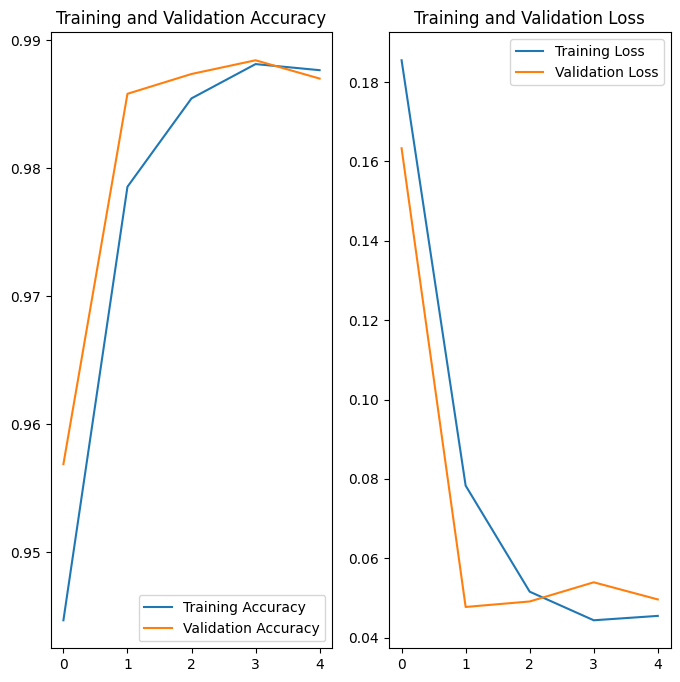

In [19]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = epochs
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()